# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Import the Data

In [2]:
df = pd.read_csv("data/diabetes.csv")
df.shape

(768, 9)

The data set contains 768 rows and 9 columns.

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Feature Engineering

Based on the exploratory data analysis, I will proceed with feature engineering.

## Dealing with Missing Data

From the EDA, we know the zero values of variables `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI` are in fact missing values. First, we will change the values of 0 to missing values and then fill them with other values.

In [4]:
cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols] = df[cols].replace(0, np.nan)

In [5]:
group_outcome = df.groupby(["Outcome"])[cols].agg(["mean", "median"])
group_outcome

Glucose        BloodPressure        SkinThickness         \
               mean median          mean median          mean median   
Outcome                                                                
0        110.643863  107.0     70.877339   70.0     27.235457   27.0   
1        142.319549  140.0     75.321429   74.5     33.000000   32.0   

            Insulin               BMI         
               mean median       mean median  
Outcome                                       
0        130.287879  102.5  30.859674   30.1  
1        206.846154  169.5  35.406767   34.3

In [6]:
df.loc[(df["Outcome"] == 1) & (df['Glucose'].isnull()), 'Glucose'] = group_outcome.iloc[1,1]
df.loc[(df["Outcome"] == 0) & (df['Glucose'].isnull()), 'Glucose'] = group_outcome.iloc[0,1]
# 인슐린 수치를 나이 또는 Glucose를 발병 여부와 함께 맞춰 채워넣을 수도 있습니다.

df.loc[(df["Outcome"] == 1) & (df['BloodPressure'].isnull()), 'BloodPressure'] = group_outcome.iloc[1,3]
df.loc[(df["Outcome"] == 0) & (df['BloodPressure'].isnull()), 'BloodPressure'] = group_outcome.iloc[0,3]

df.loc[(df["Outcome"] == 1) & (df['SkinThickness'].isnull()), 'SkinThickness'] = group_outcome.iloc[1,5]
df.loc[(df["Outcome"] == 0) & (df['SkinThickness'].isnull()), 'SkinThickness'] = group_outcome.iloc[0,5]

df.loc[(df["Outcome"] == 1) & (df['Insulin'].isnull()), 'Insulin'] = group_outcome.iloc[1,7]
df.loc[(df["Outcome"] == 0) & (df['Insulin'].isnull()), 'Insulin'] = group_outcome.iloc[0,7]

df.loc[(df["Outcome"] == 1) & (df['BMI'].isnull()), 'BMI'] = group_outcome.iloc[1,9]
df.loc[(df["Outcome"] == 0) & (df['BMI'].isnull()), 'BMI'] = group_outcome.iloc[0,9]

In [7]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


## Discretization

As said before, when classifying through tree-based algorithms, there is a risk of overfitting if the range of numerical variables is too wide. So let's do discretization for some variables.

### `Pregnancies`

We see in the EDA that when the number of pregnancies was greater than 6, it was found that the number of non-diabetes patients was higher. Therefore, we create a binary variable `Pregnancies_high` whose value equals `True` when the number of pregnancies is larger than 6 and 0 otherwise. 

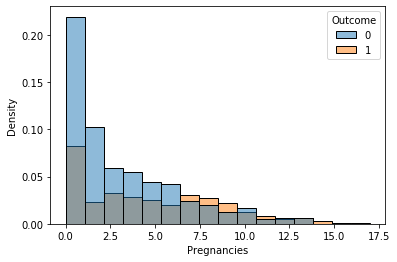

In [8]:
sns.histplot(data=df, x='Pregnancies', hue='Outcome', stat='density')

In [9]:
df["Pregnancies_high"] = df["Pregnancies"] > 6
df[["Pregnancies", "Pregnancies_high"]].head()

,Pregnancies,Pregnancies_high
0,6,False
1,1,False
2,8,True
3,1,False
4,0,False


### `Age`


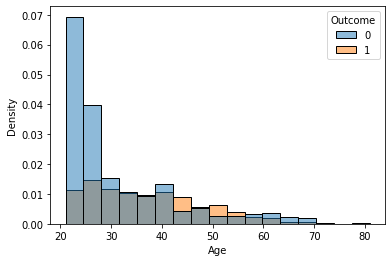

In [10]:
sns.histplot(data=df, x='Age', hue='Outcome', stat='density')

In [11]:
df["Age_low"] = df["Age"] < 43
df["Age_middle"] = (df["Age"] >= 43) & (df["Age"] <= 57)
df["Age_high"] = df["Age"] > 57
df[["Age", "Age_low", "Age_middle", "Age_high"]].head()

,Age,Age_low,Age_middle,Age_high
0,50,False,True,False
1,31,True,False,False
2,32,True,False,False
3,21,True,False,False
4,33,True,False,False


## Normalization

We normalize variables with a skewed distribution because if the data concentrated on one side makes learning difficult.

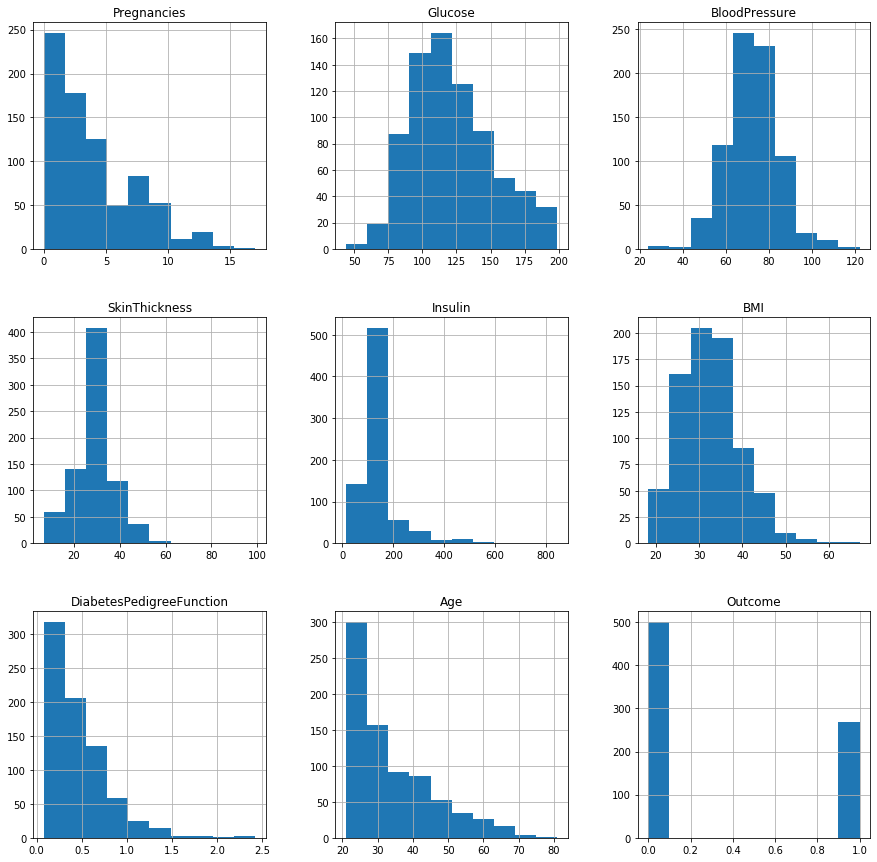

In [12]:
h = df.hist(figsize=(15,15))

In [13]:
df["Insulin_log"] = np.log(df["Insulin"]+1)
df['SkinThickness_log'] = np.log(df['SkinThickness']+1)
df['BMI_log'] = np.log(df['BMI']+1)
df['DiabetesPedigreeFunction_log'] = np.log(df['DiabetesPedigreeFunction'])

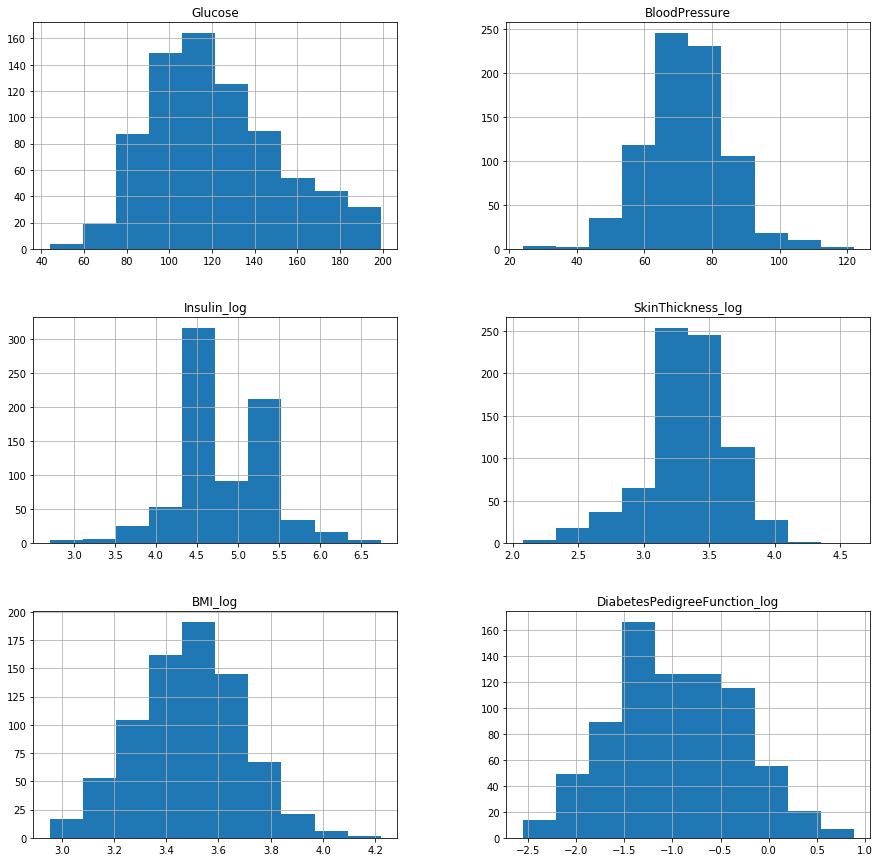

In [14]:
cols = ['Glucose','BloodPressure','Insulin_log','SkinThickness_log','BMI_log','DiabetesPedigreeFunction_log']
h = df.loc[:,cols].hist(figsize=(15,15))

## Derive New Variables from Correlation Analysis

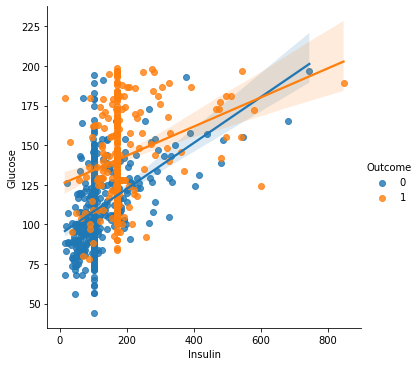

In [15]:
sns.lmplot(data=df, x="Insulin", y="Glucose", hue="Outcome")

In [16]:
df["low_glu_insulin"] = (df["Glucose"] < 125) & (df["Insulin"] <= 150)
df["low_glu_insulin"].head()

0    False
1     True
2    False
3     True
4    False
Name: low_glu_insulin, dtype: bool

In [17]:
pd.crosstab(df["Outcome"], df["low_glu_insulin"])

low_glu_insulin,False,True
Outcome,,
0,160,340
1,252,16


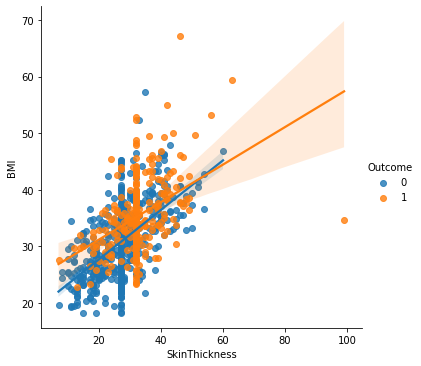

In [18]:
sns.lmplot(data=df, x="SkinThickness", y="BMI", hue="Outcome")

In [19]:
df["low_skin_bmi"] = (df["SkinThickness"] < 30) & (df["BMI"] < 30)
df["low_skin_bmi"].head()

0    False
1     True
2    False
3     True
4    False
Name: low_skin_bmi, dtype: bool

In [20]:
pd.crosstab(df["Outcome"], df["low_skin_bmi"])

low_skin_bmi,False,True
Outcome,,
0,284,216
1,247,21


## Handling outliers

In [21]:
from scipy.stats import norm

### `SkinThickness`

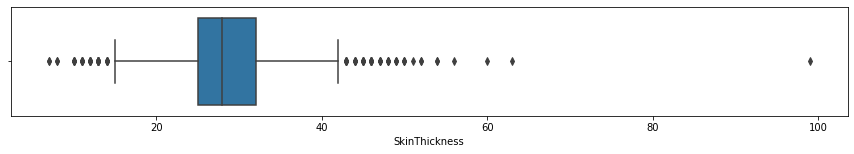

In [22]:
plt.figure(figsize=(15, 2))
sns.boxplot(data=df, x="SkinThickness")

In [23]:
df['SkinThickness'].describe()

count    768.000000
mean      29.089844
std        8.890820
min        7.000000
25%       25.000000
50%       28.000000
75%       32.000000
max       99.000000
Name: SkinThickness, dtype: float64

In [24]:
q3 = df['SkinThickness'].quantile(0.75)
q1 = df['SkinThickness'].quantile(0.25)
iqrn = (q3 - q1)/(2 * norm.ppf(0.75))
iqrn

5.189107764769607

In [25]:
outlier = (abs((df['SkinThickness'] - df['SkinThickness'].median())/iqrn) > 3)
df.drop(df[outlier].index, inplace=True)

### `DiabetesPedigreeFunction`

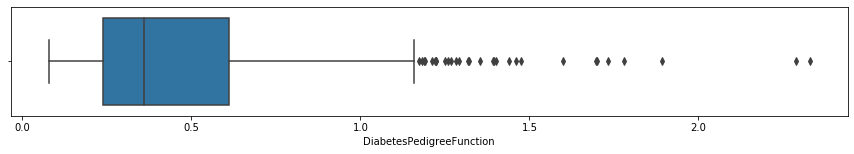

In [26]:
plt.figure(figsize=(15, 2))
sns.boxplot(data=df, x="DiabetesPedigreeFunction")

In [27]:
df['DiabetesPedigreeFunction'].describe()

count    704.000000
mean       0.461376
std        0.321012
min        0.078000
25%        0.238000
50%        0.359500
75%        0.610500
max        2.329000
Name: DiabetesPedigreeFunction, dtype: float64

In [28]:
q3 = df['DiabetesPedigreeFunction'].quantile(0.75)
q1 = df['DiabetesPedigreeFunction'].quantile(0.25)
iqrn = (q3 - q1)/(2 * norm.ppf(0.75))
iqrn

0.2761346631966684

In [29]:
outlier = (abs((df['DiabetesPedigreeFunction'] - df['DiabetesPedigreeFunction'].median())/iqrn) > 3)
df.drop(df[outlier].index, inplace=True)

### `Insulin`

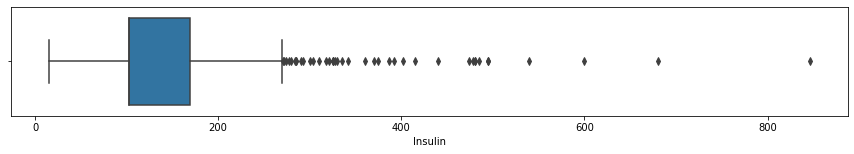

In [30]:
plt.figure(figsize = (15, 2))
sns.boxplot(data = df, x = "Insulin")

In [31]:
df["Insulin"].describe()

count    676.000000
mean     138.607988
std       82.474850
min       15.000000
25%      102.500000
50%      102.500000
75%      169.500000
max      846.000000
Name: Insulin, dtype: float64

In [32]:
q3 = df["Insulin"].quantile(0.75)
q1 = df["Insulin"].quantile(0.25)
iqrn = (q3 - q1)/(2 * norm.ppf(0.75))
iqrn

49.667174319937665

In [33]:
outlier = (abs((df['Insulin'] - df['Insulin'].median())/iqrn) > 3)
df.drop(df[outlier].index, inplace=True)

In [34]:
df.shape

(631, 19)

In [35]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_high,Age_low,Age_middle,Age_high,Insulin_log,SkinThickness_log,BMI_log,DiabetesPedigreeFunction_log,low_glu_insulin,low_skin_bmi
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,False,False,True,False,5.138735,3.583519,3.543854,-0.466809,False,False
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,False,True,False,False,4.639572,3.401197,3.317816,-1.046969,True,True
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,True,True,False,False,5.138735,3.496508,3.190476,-0.397497,False,False
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,False,True,False,False,4.553877,3.178054,3.370738,-1.789761,True,True
5,5,116.0,74.0,27.0,102.5,25.6,0.201,30,0,False,True,False,False,4.639572,3.332205,3.280911,-1.604450,True,True


After removing the outliers, there are 631 observations left in the data.

## Feature Scaling
It helps to normalize the data within a particular range.

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df[["Glucose", "DiabetesPedigreeFunction"]])
scale = scaler.transform(df[["Glucose", "DiabetesPedigreeFunction"]])
scale

array([[ 1.00834954,  0.87243451],
       [-1.16592466, -0.2688023 ],
       [ 2.21627965,  1.05850573],
       ...,
       [ 0.07651774, -0.7071034 ],
       [ 0.24907918, -0.27707214],
       [-0.88982635, -0.41765928]])

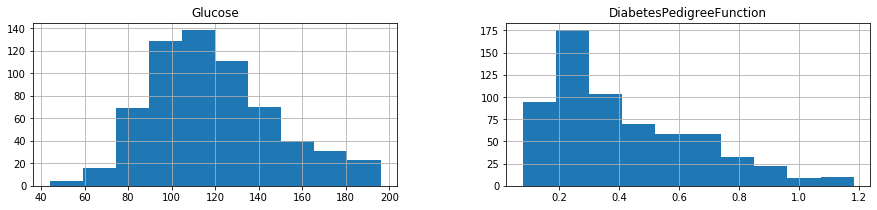

In [37]:
h = df[["Glucose", "DiabetesPedigreeFunction"]].hist(figsize = (15, 3))

## CSV 파일로 저장하기

In [38]:
df.to_csv("data/diabetes_clean.csv", index=False)

In [39]:
pd.read_csv("data/diabetes_clean.csv").head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_high,Age_low,Age_middle,Age_high,Insulin_log,SkinThickness_log,BMI_log,DiabetesPedigreeFunction_log,low_glu_insulin,low_skin_bmi
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,False,False,True,False,5.138735,3.583519,3.543854,-0.466809,False,False
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,False,True,False,False,4.639572,3.401197,3.317816,-1.046969,True,True
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,True,True,False,False,5.138735,3.496508,3.190476,-0.397497,False,False
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,False,True,False,False,4.553877,3.178054,3.370738,-1.789761,True,True
4,5,116.0,74.0,27.0,102.5,25.6,0.201,30,0,False,True,False,False,4.639572,3.332205,3.280911,-1.604450,True,True
